# TechLabs Final Project — Data Science
## Owner-Occupied Housing Price Indices in Germany (Destatis, GENESIS 61262-0003)

**Source:** Statistisches Bundesamt (Destatis), table `61262-0003` — *Preisindizes für selbst genutztes Wohneigentum*, years 2010–2024.  
All values are **indices with base 2015 = 100** (relative to year 2015).

**Notebook contents**
- Load & parse GENESIS CSV (non-standard layout).
- Data cleaning and checks.
- Feature engineering (YoY change, absolute diff, 3-year rolling mean).
- Visualizations with `matplotlib`.
- Simple trend modeling (linear regression) and a naive 2025 forecast.
- KPI summary (2015→2024 absolute/relative change, CAGR).
- Export a tidy (long) clean CSV for reuse.

> **Note:** Index components are not additive. We compare **trends and rates** across categories rather than summing them.

    

In [1]:
# ==== Setup ====
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Tidy printing
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

# Optional: confirm working directory (uncomment to see where you are)
# import os; os.getcwd()


Matplotlib is building the font cache; this may take a moment.


## 1) Load the original GENESIS CSV
- Put the file **`61262-0003_de.csv`** in the **same folder** as this notebook.
- GENESIS CSVs often mix header text + data rows. We’ll parse them robustly (UTF-8 with BOM, semicolon separated, decimal comma).


In [3]:
# Path to the downloaded CSV (adjust if needed)
csv_path = "61262-0003_de.csv"

# Read raw lines (UTF-8 with BOM is typical for Destatis downloads)
with open(csv_path, "r", encoding="utf-8-sig") as f:
    lines = [ln.rstrip("\n") for ln in f]

# Detect the line that lists the years (e.g., ';;2010;;2011; ... ;;2024;')
years = []
for ln in lines:
    if ";;2010" in ln and ";;2024" in ln:
        toks = ln.split(";")
        years = [int(t) for t in toks if re.fullmatch(r"\d{4}", t)]
        break

if not years:
    raise RuntimeError("Could not detect the year header. Please check the CSV content.")

# Parse data rows: they typically contain the string '2015=100'
rows = []
for ln in lines:
    if "2015=100" in ln:  # data row
        toks = ln.split(";")
        label = toks[0].strip()   # category name (German)
        # From index 2 onward, tokens alternate: value ; flag (e.g., 'e' estimated, 'r' revised)
        for j, y in enumerate(years):
            pos = 2 + 2*j
            val = toks[pos] if pos < len(toks) else ""
            flg = toks[pos+1] if pos+1 < len(toks) else ""
            val = val.strip()
            if val in ["", "-", "..."]:
                num = np.nan
            else:
                # Convert decimal comma to dot and remove thin spaces if present
                num = float(val.replace(",", ".").replace("\u202f", ""))
            rows.append(
                {"category": label, "year": y, "index_2015_100": num, "flag": flg.strip()}
            )

df = pd.DataFrame(rows).sort_values(["category", "year"]).reset_index(drop=True)
print("Detected categories:", len(df["category"].unique()))
df.head(12)


Detected categories: 10


,category,year,index_2015_100,flag
0,Besitz von Wohneigentum,2010,87.9,e
1,Besitz von Wohneigentum,2011,90.3,e
2,Besitz von Wohneigentum,2012,93.3,e
3,Besitz von Wohneigentum,2013,95.9,e
4,Besitz von Wohneigentum,2014,98.0,e
5,Besitz von Wohneigentum,2015,100.0,e
6,Besitz von Wohneigentum,2016,102.4,e
7,Besitz von Wohneigentum,2017,105.5,e
8,Besitz von Wohneigentum,2018,109.5,e
9,Besitz von Wohneigentum,2019,114.7,e


## 2) Cleaning & quick checks
- `index_2015_100` is numeric (floats), `NaN` where GENESIS shows `-`/`...`.
- `flag` marks Destatis notes: `e` = estimated, `r` = revised.
- We’ll check ranges and missing values per category.


In [4]:
print(df.groupby("category")["index_2015_100"].agg(["count","min","max","mean"]).round(2))
print("\nYear coverage:", df["year"].min(), "→", df["year"].max())
print("\nMissing per category:")
print(df.groupby("category")["index_2015_100"].apply(lambda s: s.isna().sum()))


                                              count    min    max    mean
category                                                                 
Besitz von Wohneigentum                          15   87.9  167.0  114.23
Eigenbau, Fertigteilbau und Umbau                15   90.0  164.4  114.73
Erwerb von Wohneigentum                          15   88.3  160.7  114.65
Erwerbsnebenkosten                               15   72.5  158.6  112.95
Hausverwaltung                                    8  104.6  126.9  114.22
Instandhaltung                                   15   87.7  168.0  114.53
Preisindex für selbst genutztes Wohneigentum     15   88.3  161.4  114.62
Schlüsselfertiges Bauen                          15   83.6  148.7  114.55
Versicherungen                                   15   88.3  175.3  115.87
Wohneigentum                                     15   89.4  162.0  114.75

Year coverage: 2010 → 2024

Missing per category:
category
Besitz von Wohneigentum                         0
Ei

## 3) Feature engineering
We add:
- **`diff_prev`**: absolute change vs previous year.
- **`pct_change`**: year-over-year % change.
- **`rolling_mean_3`**: 3-year rolling mean (trend smoother).


In [5]:
df = df.sort_values(["category", "year"]).copy()
df["diff_prev"]   = df.groupby("category")["index_2015_100"].diff(1)
df["pct_change"]  = df.groupby("category")["index_2015_100"].pct_change(1) * 100
df["rolling_mean_3"] = df.groupby("category")["index_2015_100"].transform(
    lambda s: s.rolling(3, min_periods=1).mean()
)

df.head(10)


/var/folders/jh/r0b4lzr90k1ck940x9skkgcc0000gn/T/ipykernel_2277/3015359261.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df["pct_change"]  = df.groupby("category")["index_2015_100"].pct_change(1) * 100


,category,year,index_2015_100,flag,diff_prev,pct_change,rolling_mean_3
0,Besitz von Wohneigentum,2010,87.9,e,NaN,NaN,87.900000
1,Besitz von Wohneigentum,2011,90.3,e,2.4,2.730375,89.100000
2,Besitz von Wohneigentum,2012,93.3,e,3.0,3.322259,90.500000
3,Besitz von Wohneigentum,2013,95.9,e,2.6,2.786710,93.166667
4,Besitz von Wohneigentum,2014,98.0,e,2.1,2.189781,95.733333
5,Besitz von Wohneigentum,2015,100.0,e,2.0,2.040816,97.966667
6,Besitz von Wohneigentum,2016,102.4,e,2.4,2.400000,100.133333
7,Besitz von Wohneigentum,2017,105.5,e,3.1,3.027344,102.633333
8,Besitz von Wohneigentum,2018,109.5,e,4.0,3.791469,105.800000
9,Besitz von Wohneigentum,2019,114.7,e,5.2,4.748858,109.900000


## 4) Visualizations (matplotlib)
One chart per figure, no special styles/colors (kept simple and portable).


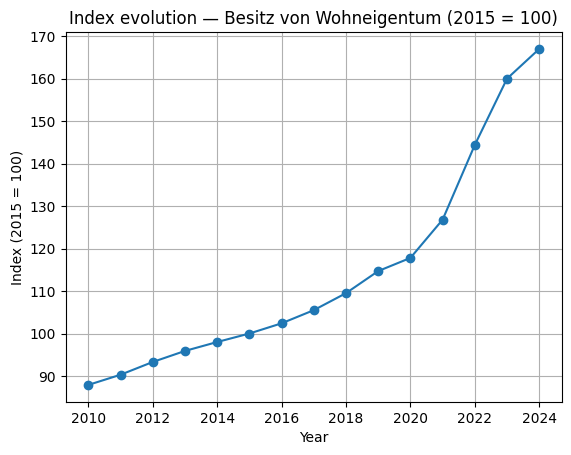

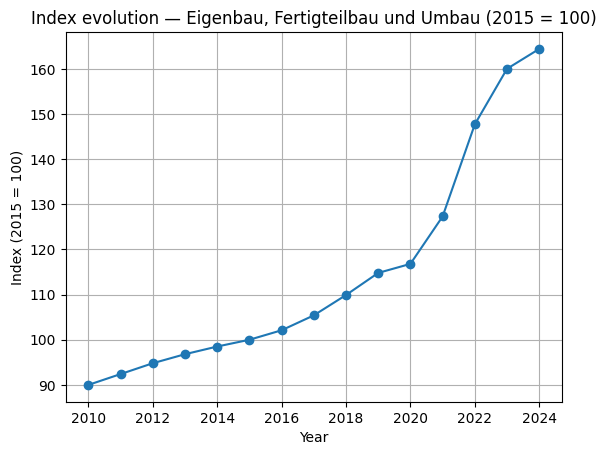

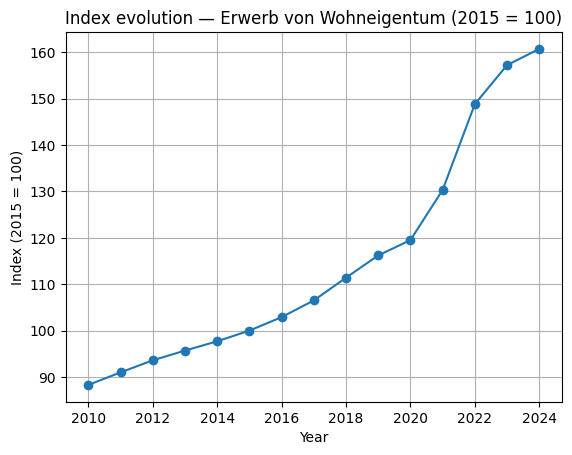

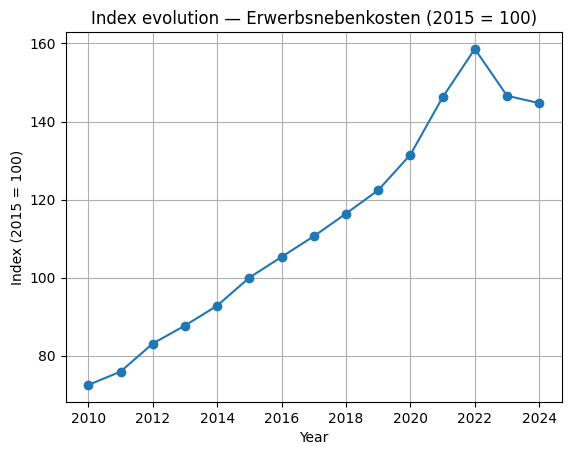

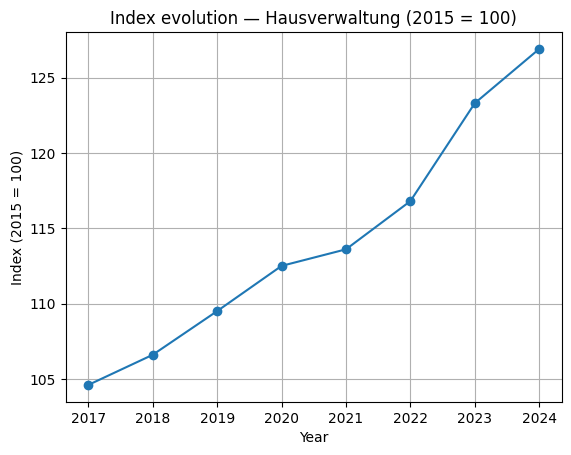

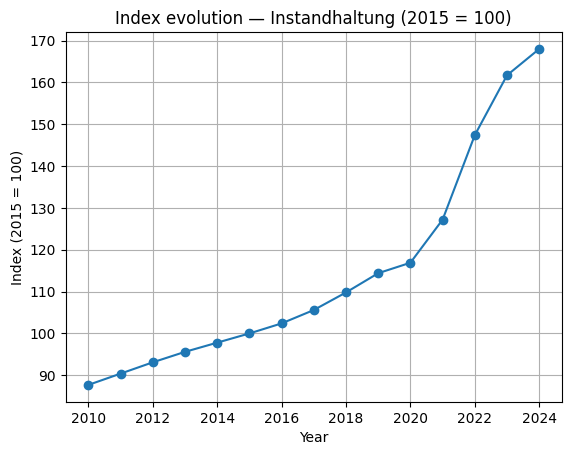

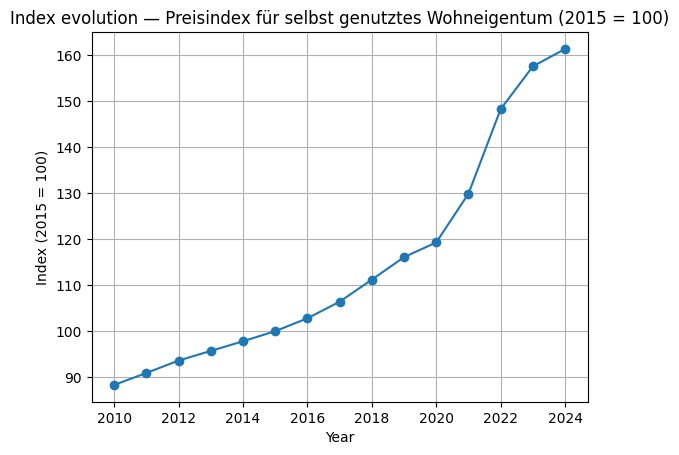

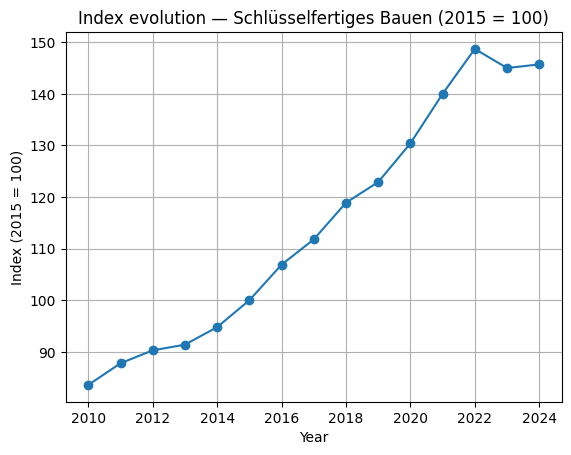

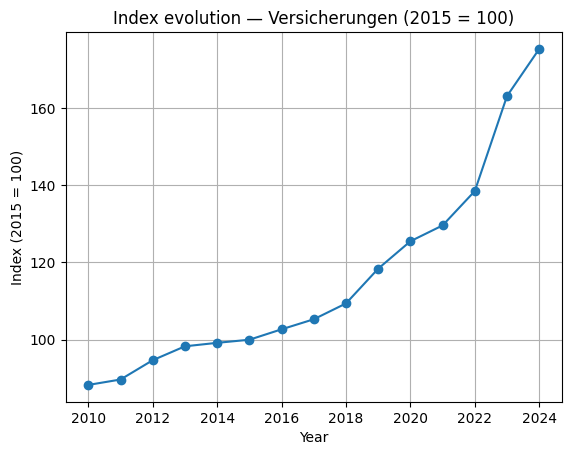

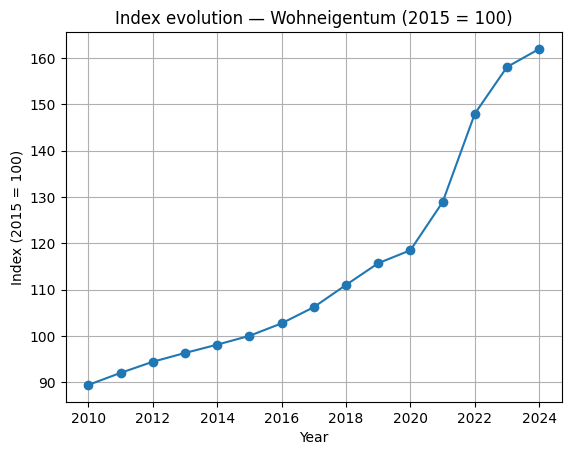

In [6]:
# 4.1 Time series for each category
for cat in df["category"].unique():
    tmp = df[df["category"] == cat]
    plt.figure()
    plt.plot(tmp["year"], tmp["index_2015_100"], marker="o")
    plt.title(f"Index evolution — {cat} (2015 = 100)")
    plt.xlabel("Year")
    plt.ylabel("Index (2015 = 100)")
    plt.grid(True)
    plt.show()


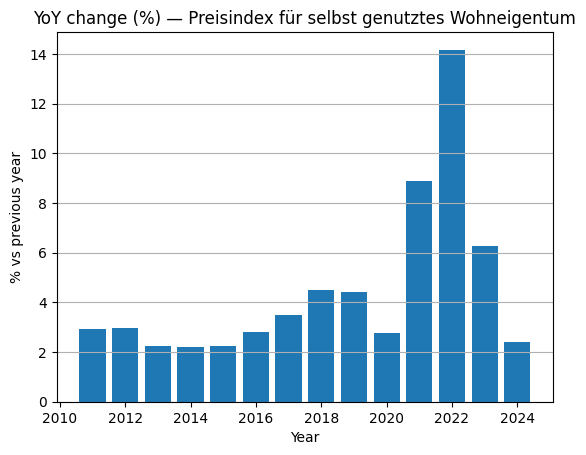

In [7]:
# 4.2 YoY % change for the headline index (adjust the name if needed)
main_cat = "Preisindex für selbst genutztes Wohneigentum"
tmp = df[df["category"] == main_cat].copy()

plt.figure()
plt.bar(tmp["year"], tmp["pct_change"])
plt.title(f"YoY change (%) — {main_cat}")
plt.xlabel("Year")
plt.ylabel("% vs previous year")
plt.grid(True, axis="y")
plt.show()


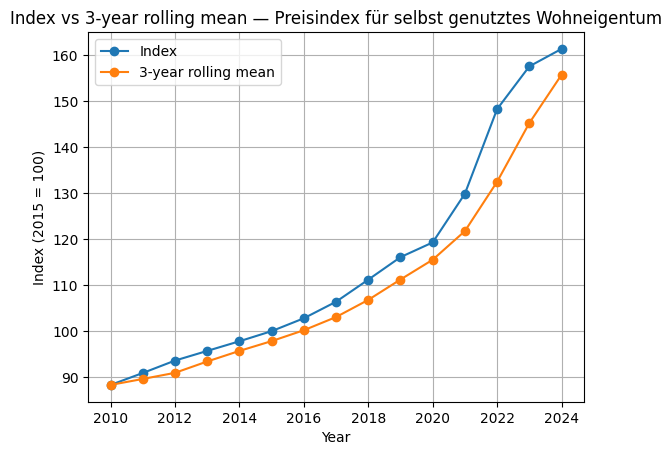

In [8]:
# 4.3 3-year rolling mean vs original (headline index)
plt.figure()
plt.plot(tmp["year"], tmp["index_2015_100"], marker="o", label="Index")
plt.plot(tmp["year"], tmp["rolling_mean_3"], marker="o", label="3-year rolling mean")
plt.title(f"Index vs 3-year rolling mean — {main_cat}")
plt.xlabel("Year")
plt.ylabel("Index (2015 = 100)")
plt.legend()
plt.grid(True)
plt.show()


## 5) KPIs: 2015→2024 absolute/relative change and CAGR
For each category, compute:
- `val_2015`, `val_2024`
- `abs_change` = 2024 − 2015
- `rel_change_%` = (2024 / 2015 − 1) × 100
- `CAGR_%` = (2024 / 2015)^(1/years) − 1, with years = 9 (2015→2024)


In [9]:
def val_at(g, year):
    s = g.loc[g["year"] == year, "index_2015_100"]
    return s.iloc[0] if not s.empty else np.nan

rows = []
for cat, g in df.groupby("category"):
    v15 = val_at(g, 2015)
    v24 = val_at(g, 2024)
    if pd.notna(v15) and pd.notna(v24) and v15 > 0:
        abs_change = v24 - v15
        rel_change = (v24 / v15) - 1.0
        years = 2024 - 2015
        cagr = (v24 / v15) ** (1/years) - 1.0
    else:
        abs_change = np.nan
        rel_change = np.nan
        cagr = np.nan

    rows.append({
        "category": cat,
        "val_2015": v15,
        "val_2024": v24,
        "abs_change_2015_2024": abs_change,
        "rel_change_2015_2024_%": rel_change * 100 if pd.notna(rel_change) else np.nan,
        "CAGR_2015_2024_%": cagr * 100 if pd.notna(cagr) else np.nan
    })

summary = pd.DataFrame(rows).sort_values("CAGR_2015_2024_%", ascending=False)
summary.round(2)


,category,val_2015,val_2024,abs_change_2015_2024,rel_change_2015_2024_%,CAGR_2015_2024_%
8,Versicherungen,100.0,175.3,75.3,75.3,6.44
5,Instandhaltung,100.0,168.0,68.0,68.0,5.93
0,Besitz von Wohneigentum,100.0,167.0,67.0,67.0,5.86
1,"Eigenbau, Fertigteilbau und Umbau",100.0,164.4,64.4,64.4,5.68
9,Wohneigentum,100.0,162.0,62.0,62.0,5.51
6,Preisindex für selbst genutztes Wohneigentum,100.0,161.4,61.4,61.4,5.46
2,Erwerb von Wohneigentum,100.0,160.7,60.7,60.7,5.41
7,Schlüsselfertiges Bauen,100.0,145.7,45.7,45.7,4.27
3,Erwerbsnebenkosten,100.0,144.7,44.7,44.7,4.19
4,Hausverwaltung,NaN,126.9,NaN,NaN,NaN


## 6) Linear trend by category
We fit a simple linear regression **Index ~ Year** for each category to get:
- **Slope** (average increase per year)
- **R²** (goodness of fit)

> This is a **naive trend model** meant for characterization, not for structural forecasting.


In [10]:
lin_rows = []
for cat, g in df.dropna(subset=["index_2015_100"]).groupby("category"):
    X = g[["year"]].values
    y = g["index_2015_100"].values
    if len(g) >= 3:
        lr = LinearRegression().fit(X, y)
        slope = lr.coef_[0]
        r2 = lr.score(X, y)
        lin_rows.append({"category": cat, "slope_per_year": slope, "R2": r2})
    else:
        lin_rows.append({"category": cat, "slope_per_year": np.nan, "R2": np.nan})

lin_summary = pd.DataFrame(lin_rows).sort_values("slope_per_year", ascending=False)
lin_summary.round(3)


,category,slope_per_year,R2
3,Erwerbsnebenkosten,6.118,0.957
8,Versicherungen,5.414,0.853
5,Instandhaltung,5.290,0.853
0,Besitz von Wohneigentum,5.167,0.859
7,Schlüsselfertiges Bauen,5.103,0.970
6,Preisindex für selbst genutztes Wohneigentum,5.098,0.887
2,Erwerb von Wohneigentum,5.088,0.890
1,"Eigenbau, Fertigteilbau und Umbau",5.019,0.845
9,Wohneigentum,5.015,0.872
4,Hausverwaltung,3.126,0.963


## 7) Naive forecast for 2025 (linear extrapolation)
Using the linear model above, we predict 2025 for each category.

> **Caution:** This ignores shocks, cycles, and regime changes. Treat as a simple illustration.


In [11]:
pred_rows = []
for cat, g in df.dropna(subset=["index_2015_100"]).groupby("category"):
    X = g[["year"]].values
    y = g["index_2015_100"].values
    if len(g) >= 3:
        lr = LinearRegression().fit(X, y)
        pred_2025 = lr.predict([[2025]])[0]
    else:
        pred_2025 = np.nan
    pred_rows.append({"category": cat, "pred_2025_linear": pred_2025})

pred_2025_df = pd.DataFrame(pred_rows).merge(lin_summary, on="category", how="left")
pred_2025_df.round(2)


,category,pred_2025_linear,slope_per_year,R2
0,Besitz von Wohneigentum,155.57,5.17,0.86
1,"Eigenbau, Fertigteilbau und Umbau",154.88,5.02,0.85
2,Erwerb von Wohneigentum,155.36,5.09,0.89
3,Erwerbsnebenkosten,161.90,6.12,0.96
4,Hausverwaltung,128.29,3.13,0.96
5,Instandhaltung,156.86,5.29,0.85
6,Preisindex für selbst genutztes Wohneigentum,155.40,5.10,0.89
7,Schlüsselfertiges Bauen,155.37,5.10,0.97
8,Versicherungen,159.18,5.41,0.85
9,Wohneigentum,154.87,5.01,0.87


## 8) Export a clean, tidy CSV (optional)
We keep **one row per category-year**, with derived columns included.


In [12]:
out_path = "destatis_61262_0003_clean.csv"
df.to_csv(out_path, index=False)
print("Saved:", out_path, "| rows:", len(df))
df.sample(8).sort_values(["category","year"]).head(8)


Saved: destatis_61262_0003_clean.csv | rows: 150


,category,year,index_2015_100,flag,diff_prev,pct_change,rolling_mean_3
7,Besitz von Wohneigentum,2017,105.5,e,3.1,3.027344,102.633333
20,"Eigenbau, Fertigteilbau und Umbau",2015,100.0,e,1.5,1.522843,98.433333
37,Erwerb von Wohneigentum,2017,106.5,e,3.6,3.498542,103.133333
53,Erwerbsnebenkosten,2018,116.4,e,5.8,5.244123,110.766667
67,Hausverwaltung,2017,104.6,e,NaN,NaN,104.600000
105,Schlüsselfertiges Bauen,2010,83.6,e,NaN,NaN,83.600000
124,Versicherungen,2014,99.2,e,0.9,0.915565,97.400000
130,Versicherungen,2020,125.5,e,7.1,5.996622,117.766667


## 9) Conclusions (template to fill in)
- **Overall trend (2010–2024):** Describe the headline index trajectory.
- **Components that moved fastest:** Use CAGR and slopes to justify.
- **Notable periods:** Mark years with abnormal changes (e.g., 2020–2022).
- **Limitations:** Indices are relative to 2015 and non-additive.
- **Next steps:** Optionally contrast with inflation or median income series to contextualize affordability.
